# Measuring realised volatility

This notebook looks into various ways of measuring realised (historical) volatility that are invented over the past decades. They typically use the full OHLC data set in order to alleviate problems that arise from the traditional close-to-close standard deviations. In this notebook, the following measures are studied:
- Rolling standard deviation using close-to-close
- Exponentially weighted standard deviation using close-to-close
- Parkinson
- Garman-Klass
- Rogers-Satchell
- Garman-Klass Yang-Zhang
- Yang-Zhang

Among these measures, according to the study by Santander, Yang-Zhang is most efficient (less variance in the context of bias-variance) against the standard close-to-close volatility. However they also mentioned that a far less benefit is observed with real data.

Then we later see the effect of using these alternative meausres to create a volatility-scaled long-only. As Baltas 2020 reported, they tend to yield more stable volatility estimates and hence lower turnover while achieving more or less the same targeted volatility.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest import processing
from vivace.backtest.contract import all_futures_baltas2020
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.enums import Strategy, RealisedVolatility
from vivace.backtest.stats import Performance, PerfStats

# Case study - E-mini S&P futures

The E-mini S&P futures is used as a case study. Like other notebooks, all analysis rely on the backtest engine provided by a private library `vivace`.

## Calculate realised volatilities

In [2]:
rv_kwargs = (
    {'name': 'Rolling standard deviation',
     'volatility_type': RealisedVolatility.STANDARD.value, 'agg_method': 'rolling', 'window': 21},
    {'name': 'Exponentially weighted standard deviation',
     'volatility_type': RealisedVolatility.STANDARD.value, 'agg_method': 'ewm', 'halflife': 10},
    {'name': 'Parkinson',
     'volatility_type': RealisedVolatility.PARKINSON.value, 'agg_method': 'rolling', 'window': 21},
    {'name': 'Garman-Klass', 
     'volatility_type': RealisedVolatility.GK.value, 'agg_method': 'rolling', 'window': 21},
    {'name': 'Rogers-Satchell', 
     'volatility_type': RealisedVolatility.RS.value, 'agg_method': 'rolling', 'window': 21},
    {'name': 'Garman-Klass Yang-Zhang', 
     'volatility_type': RealisedVolatility.GKYZ.value, 'agg_method': 'rolling', 'window': 21},
    {'name': 'Yang-Zhang', 
     'volatility_type': RealisedVolatility.YZ.value, 'agg_method': 'rolling', 'window': 21},
)

In [3]:
rv_names = [i['name'] for i in rv_kwargs]
rv_names

['Rolling standard deviation',
 'Exponentially weighted standard deviation',
 'Parkinson',
 'Garman-Klass',
 'Rogers-Satchell',
 'Garman-Klass Yang-Zhang',
 'Yang-Zhang']

In [4]:
engines = []
for rv_kwarg in rv_kwargs:
    name = rv_kwarg.get('name')
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument='ES',
        signal=signal.VolatilityScale(min_periods=10, **rv_kwarg),
        log_level=logging.WARNING,
    )
    engine.run()
    engines.append([name, engine])

In [5]:
# Summarise different volatility measures
es_realised_volatility = []
for name, engine in engines:
    es_realised_volatility.append(
        engine.pipeline.pipeline[0].realised_volatility['ES'].rename(name)
    )
es_realised_volatility = pd.concat(es_realised_volatility, axis=1)

## Calculate long-only performance
Compute long-only performance to see the relationship against realised volatility.

In [6]:
engine_long_only = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument='ES',
    log_level=logging.WARNING,
)
engine_long_only.run()

In [7]:
es_long_only = engine_long_only.calculate_equity_curve(calculate_net=False)

## Long-term comparison
Overall all volatility measures seem to have behaved similarly.

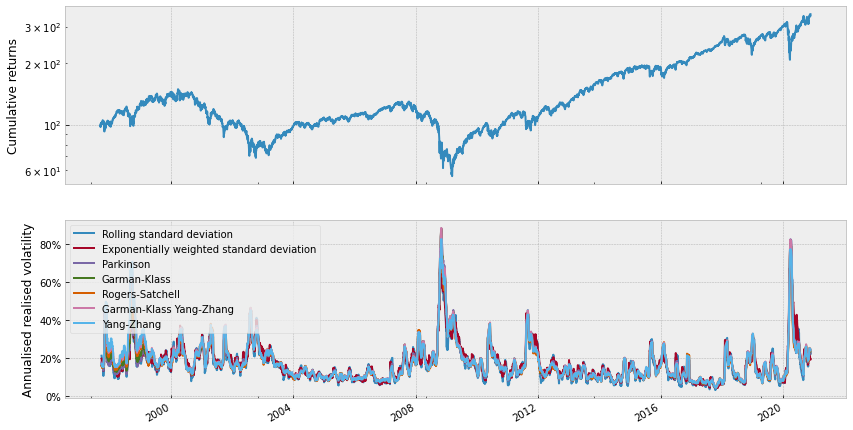

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
es_long_only.plot(ax=ax[0], logy=True)
ax[0].set_ylabel('Cumulative returns')

es_realised_volatility.plot(ax=ax[1])
ax[1].legend(loc='upper left')
ax[1].set_ylabel('Annualised realised volatility')
ax[1].yaxis.set_major_formatter(mticker.PercentFormatter(1));

In [9]:
es_realised_volatility.describe()

,Rolling standard deviation,Exponentially weighted standard deviation,Parkinson,Garman-Klass,Rogers-Satchell,Garman-Klass Yang-Zhang,Yang-Zhang
count,5843.000000,5843.000000,5844.000000,5844.000000,5844.000000,5843.000000,5843.000000
mean,0.166019,0.168458,0.168867,0.171294,0.169840,0.177149,0.174848
std,0.096264,0.091309,0.101129,0.101418,0.098318,0.107506,0.105126
min,0.031368,0.040670,0.041215,0.042744,0.044436,0.043189,0.043158
25%,0.099405,0.105482,0.104488,0.106048,0.104886,0.107775,0.105817
50%,0.146807,0.149118,0.145455,0.147005,0.145422,0.150781,0.148834
75%,0.204533,0.203900,0.202615,0.205120,0.207978,0.214366,0.211803
max,0.819327,0.720127,0.881730,0.880186,0.809297,0.883712,0.825719


## Compariosn in 2020 
In 2020, there was a surge in SP realised volatility and it reached around 80%. The rolling standard deviation tends to jump up and down whenever a large return is included/dropped from the estimation window (21 days) such as in June and July. This effect is almost absent for the OHLC based measures.

The exponentially weighted standard deviation is calculated differently in a sense that it uses all historical returns with decaying weights. In this analysis, a halflife of 10 days is used and it has somewhat a slower decay than the other rolling window based measures. As a result, the exponential weighting was still elevated in May.

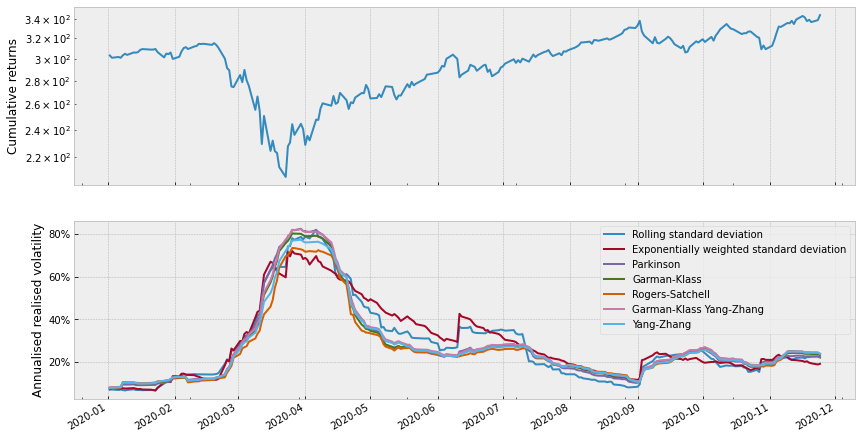

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
es_long_only['2020'].plot(ax=ax[0], logy=True)
ax[0].set_ylabel('Cumulative returns')

es_realised_volatility['2020'].plot(ax=ax[1])
ax[1].set_ylabel('Annualised realised volatility')
ax[1].yaxis.set_major_formatter(mticker.PercentFormatter(1));

Another interesting thing is close-to-close based measures (both rolling and exponentially weighted) have a flat period in March 2020 while other measures were still rising. This indicates some intraday volatility.

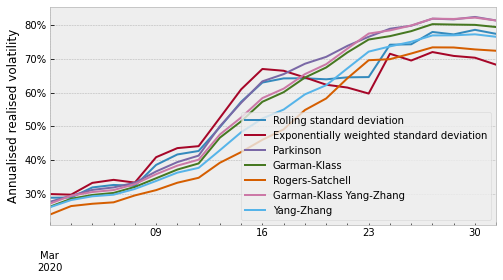

In [11]:
ax = es_realised_volatility['2020-03'].plot(figsize=(8, 4))
ax.set_ylabel('Annualised realised volatility')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))

## Volatility scaled long-only

Let's see what happens if these alternative measures are used for volatility-scaled long-only.

In [12]:
es_vol_scaled_long_only = []
es_vol_scaled_position = []
for name, engine in engines:
    es_vol_scaled_long_only.append(
        engine.calculate_equity_curve(calculate_net=False).rename(name)
    )
    es_vol_scaled_position.append(
        engine.get_position_by_instrument().squeeze().rename(name)
    )
es_vol_scaled_long_only = pd.concat(es_vol_scaled_long_only, axis=1)
es_vol_scaled_position = pd.concat(es_vol_scaled_position, axis=1)

Performance-wise, there doesn't seem to be a major difference.

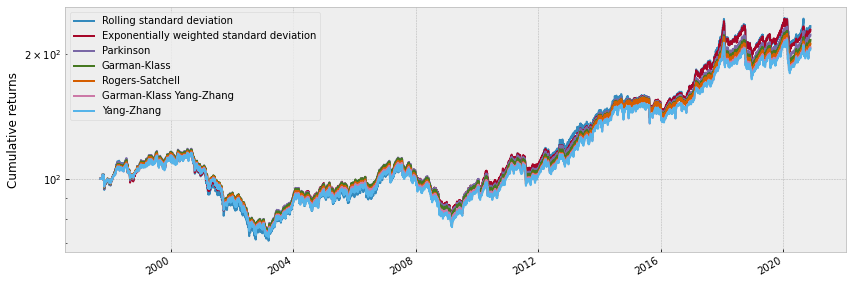

In [13]:
ax = es_vol_scaled_long_only.plot(figsize=(14, 5), logy=True)
ax.set_ylabel('Cumulative returns');

In [14]:
es_vol_scaled_long_only.pipe(Performance).summary()

,Rolling standard deviation,Exponentially weighted standard deviation,Parkinson,Garman-Klass,Rogers-Satchell,Garman-Klass Yang-Zhang,Yang-Zhang
annualised return,0.043552,0.042018,0.040848,0.039363,0.038608,0.037345,0.037194
annualised vol,0.118280,0.112220,0.112309,0.110398,0.111543,0.107972,0.109591
Sharpe ratio,0.368212,0.374425,0.363712,0.356554,0.346123,0.345874,0.339394
max drawdown,0.391621,0.365540,0.371815,0.371023,0.374656,0.372225,0.375560
Calmar ratio,0.111210,0.114947,0.109861,0.106093,0.103048,0.100328,0.099037
skewness,-0.739552,-0.783207,-0.740269,-0.743316,-0.755113,-0.747052,-0.760184
kurtosis,5.871504,5.917588,5.267490,5.350844,5.613986,5.438189,5.636599
worst return,-0.065894,-0.063985,-0.063325,-0.065794,-0.070571,-0.065278,-0.069070
worst 1d return,-0.065894,-0.063985,-0.063325,-0.065794,-0.070571,-0.065278,-0.069070
worst 1w return,-0.081644,-0.098947,-0.094603,-0.097521,-0.099905,-0.095163,-0.095238


Empirically, all vol-scaled long-only achieved returns with realised volatility in line with the target (10%) on average. However there are very large variations in realised volatility (high vol-of-vol). This seems to be somewhat apparent more recently.

In [15]:
es_vol_scaled_realised_vol = es_vol_scaled_long_only.pct_change().rolling(21).std().mul(252 ** 0.5)

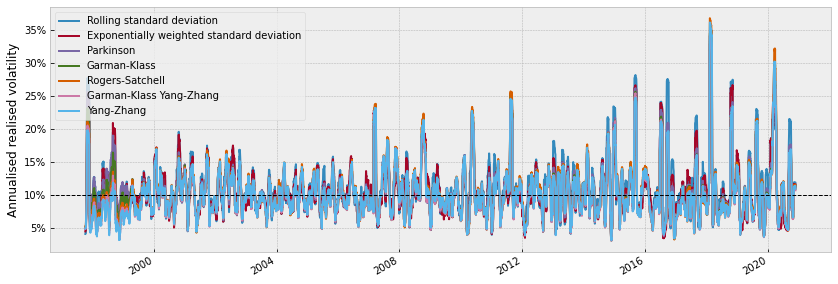

In [16]:
ax = es_vol_scaled_realised_vol.plot(figsize=(14, 5))

ax.axhline(0.1, color='black', lw=1, ls='--')
ax.set_ylabel('Annualised realised volatility')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0));

Although all the measures more or less achieved the targeted volatility, the Garman-Klass Yang-Zhang had slightly better accuracy while the rolling standard deviation slightly overshot.

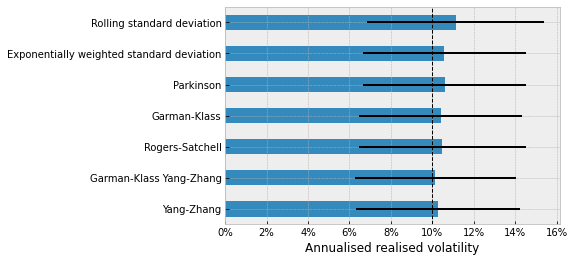

In [17]:
ax = es_vol_scaled_realised_vol.mean().iloc[::-1].plot(kind='barh', xerr=es_vol_scaled_realised_vol.std())
ax.axvline(0.1, color='black', lw=1, ls='--')

ax.set_xlabel('Annualised realised volatility')
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0));

The chart below shows the historical position size in order to target the desired volatility level. In high-vol environment, it scaled down below 100% to keep the same risk amount such as in 2008 and 2020.

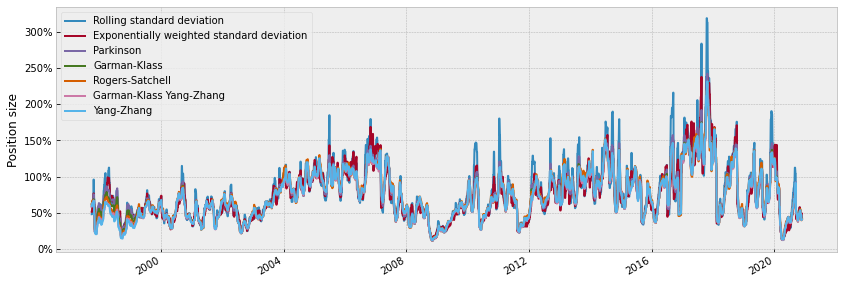

In [18]:
ax = es_vol_scaled_position.plot(figsize=(14, 5));

ax.set_ylabel('Position size')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0));

Another interesting this is that the rolling standard deviation has significantly higher turnover than the other measures. It historically had to trade 500% annual turnover in order to target the volatility. Naturally higher turnover means higher transaction costs and given all measures achieved more or less the same performance, the rolling standard deviation is less efficient way to target volatility.

On the other hand, again the Garman-Klass Yang-Zhang had the smallest turnover around 300%. The same improvement was observed in Baltas 2020 albeit they used the Yang-Zhang method.

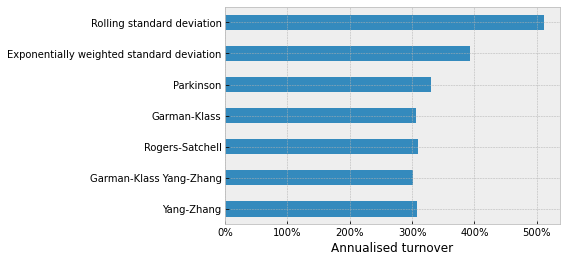

In [19]:
ax = es_vol_scaled_position.diff().abs().mean().mul(252).iloc[::-1].plot(kind='barh');

ax.set_xlabel('Annualised turnover')
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0));

# Other futures contracts

In this section, the same analysis is applied to a wider universe in the 4 asset classes whether to see this is S&P specific.
There are 3 statistics reported
- Average realised volatility: The average of realise volatility in volatility-scaled long-only
- Volatility of volatility: The standard deviation of realise volatility in volatility-scaled long-only. This captures the stability of volatility scaling
- Turnover reduction: The reuction in turnover relative to the rolling standard deviation.

In [20]:
all_futures_baltas2020['name'].values

array(['Light Sweet Crude Oil Futures', 'Brent Crude Oil',
       'NY Harbor ULSD Futures', 'Henry Hub Natural Gas Futures',
       'RBOB Gasoline Futures', 'Copper Futures', 'Gold Futures',
       'Palladium Futures', 'Platinum Futures', 'Silver Futures',
       'Feeder Cattle Futures', 'Live Cattle Futures', 'Lean Hog Futures',
       'Corn Futures', 'Oats', 'Soybean Oil Futures',
       'Soybean Meal Futures', 'Soybean Futures', 'Wheat Futures',
       'Cocoa', 'Coffee C Arabica', 'Cotton #2', 'Lumber',
       'Orange Juice [FCOJ-A]', 'Sugar #11', 'Australian Dollar Futures',
       'Canadian Dollar Futures', 'Swiss Franc Futures',
       'Euro FX Futures', 'British Pound Futures', 'Japanese Yen Futures',
       'E-Mini Nasdaq 100', 'E-mini S&P 500 Futures',
       'E-mini Russell 2000 Index Futures', 'FTSE 100 Index Futures',
       'DAX Futures', 'CAC 40 Index', 'IBEX 35 Index',
       'Amsterdam AEX Index', 'Swiss Market Index', 'SPI 200 Index',
       'Tokyo Topix Index', 'Hang 

Because of data availability, the analysis for some contracts start from later than the introduction of futures contracts. For contracts that are not specified in `start_date_map`, backtest tries to go back as far as Dec-1974 in line with Baltas 2020.  
Furthermore, the `signal_cap` of 0.95 is employed in order to cap the leverages and forces them to be lower than trailing 95%ile of leverages. This is required because some commodity contracts sometimes have significantly large returns in the absolute sense which causes the backtest to go bust.

In [21]:
start_date_map = {
    'XB': datetime(2008, 1, 1),
    'SB': datetime(1976, 1, 1),
    'CD': datetime(1977, 1, 1),
    'JY': datetime(1978, 1, 1),
    'EC': datetime(1999, 2, 1),
    'CF': datetime(2000, 1, 1),
    'RTY': datetime(2014, 11, 1),
    'JB': datetime(2001, 10, 1),
}

In [22]:
summary = []

for instrument, row in all_futures_baltas2020.iterrows():
    start_date = start_date_map.get(instrument, datetime(1974, 12, 1))
    
    for rv_kwarg in rv_kwargs:
        rv_name = rv_kwarg.get('name')
        engine = BacktestEngine(
            start_date=start_date,
            strategy=Strategy.DELTA_ONE.value,
            instrument=instrument,
            signal=signal.VolatilityScale(min_periods=10, signal_cap=0.95, **rv_kwarg),
            log_level=logging.WARNING,
        )
        engine.run()
        
        engine_return = engine.get_return(calculate_net=False)
        rv = engine_return.rolling(21).std().mul(252 ** 0.5)
        turnover = engine.get_position_by_instrument().squeeze().diff().abs().mean() * 252
        
        summary.append([
            row['name'],
            row['asset_class'],
            rv_name,
            rv.mean(),
            rv.std(),
            turnover,
        ])
        
summary = pd.DataFrame(summary, columns=['instrument', 'asset_class', 'realised_volatility_name', 
                                         'average_realised_volatility', 'vov', 'annualised_turnover'])

In [23]:
summary

,instrument,asset_class,realised_volatility_name,average_realised_volatility,vov,annualised_turnover
0,Light Sweet Crude Oil Futures,commodity,Rolling standard deviation,0.108014,0.033671,2.346131
1,Light Sweet Crude Oil Futures,commodity,Exponentially weighted standard deviation,0.104377,0.031309,1.921508
2,Light Sweet Crude Oil Futures,commodity,Parkinson,0.110283,0.032526,1.724454
3,Light Sweet Crude Oil Futures,commodity,Garman-Klass,0.109493,0.032817,1.684010
4,Light Sweet Crude Oil Futures,commodity,Rogers-Satchell,0.113210,0.034055,1.731948
...,...,...,...,...,...,...
373,10-Year JGB Futures,fixed_income,Parkinson,0.173003,0.070606,21.586517
374,10-Year JGB Futures,fixed_income,Garman-Klass,0.170073,0.068065,20.428923
375,10-Year JGB Futures,fixed_income,Rogers-Satchell,0.168239,0.066760,20.377703
376,10-Year JGB Futures,fixed_income,Garman-Klass Yang-Zhang,0.139159,0.055846,15.931723


## Average realised volatility

For most of the contracts, volatility-scaled long-only tended to overshoot the target when Parkinson, Garman-Klass or Rogers-Satchell are used. (Realised volatility of volatility-scaled long-only are measured by the rolling standard deviation after all so they do not neccesarily need to line up).

In [24]:
def plot_average_realised_volatility(summary: pd.DataFrame, asset_class: str):
    ax = (summary.query(f'asset_class == "{asset_class}"')
     .pivot_table('average_realised_volatility', index='instrument', columns='realised_volatility_name')
     .reindex(columns=rv_names)
     .reindex(index=all_futures_baltas2020.query(f'asset_class == "{asset_class}"')['name'].tolist())
     .plot(kind='bar', figsize=(14, 4)))
    
    ax.axhline(0.1, color='black', lw=1, ls='--')
    ax.legend(loc='lower right')
    ax.set_ylabel('Average realised volatility')
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0));

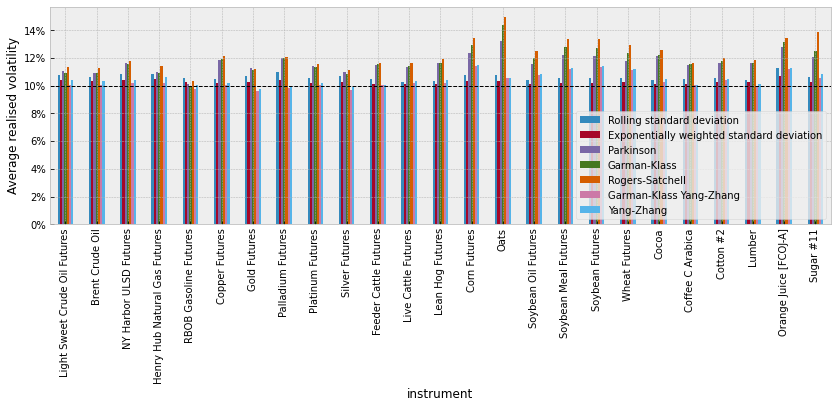

In [25]:
plot_average_realised_volatility(summary, 'commodity')

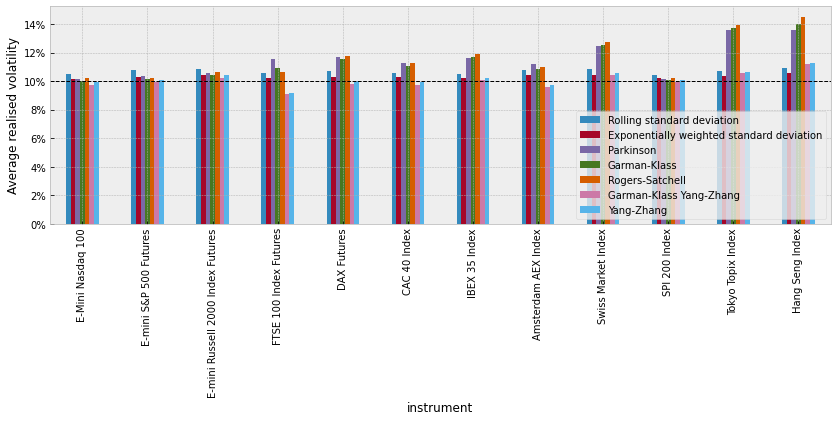

In [26]:
plot_average_realised_volatility(summary, 'equity')

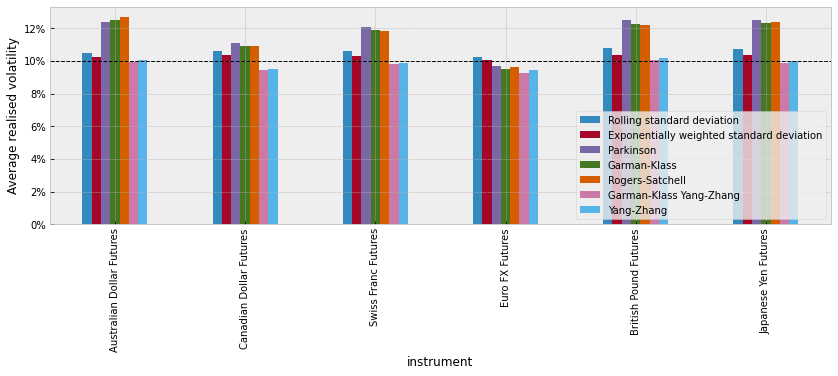

In [27]:
plot_average_realised_volatility(summary, 'currency')

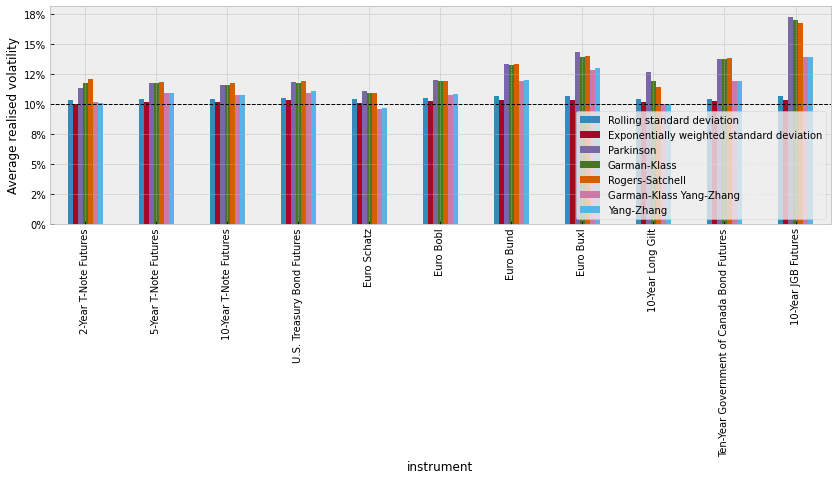

In [28]:
plot_average_realised_volatility(summary, 'fixed_income')

## Volatility of volatility

This section measures the volatility of volatility-scaled long-only, which means how volatile or stable a resulting scaled performance is. Generally speaking, the Parkinson, Garman-Klass and Rogers-Satchell tend to result in higher volatility.

In [29]:
def plot_vov(summary: pd.DataFrame, asset_class: str):
    ax = (summary.query(f'asset_class == "{asset_class}"')
          .pivot_table('vov', index='instrument', columns='realised_volatility_name')
          .reindex(columns=rv_names)
          .reindex(index=all_futures_baltas2020.query(f'asset_class == "{asset_class}"')['name'].tolist())
          .plot(kind='bar', figsize=(14, 4)))
    
    ax.legend(loc='upper right')
    ax.set_ylabel('Volatility of realised volatility')
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0));

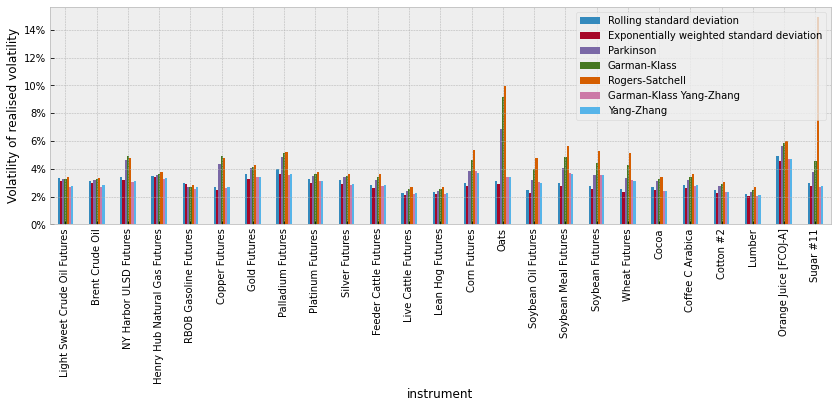

In [30]:
plot_vov(summary, 'commodity')

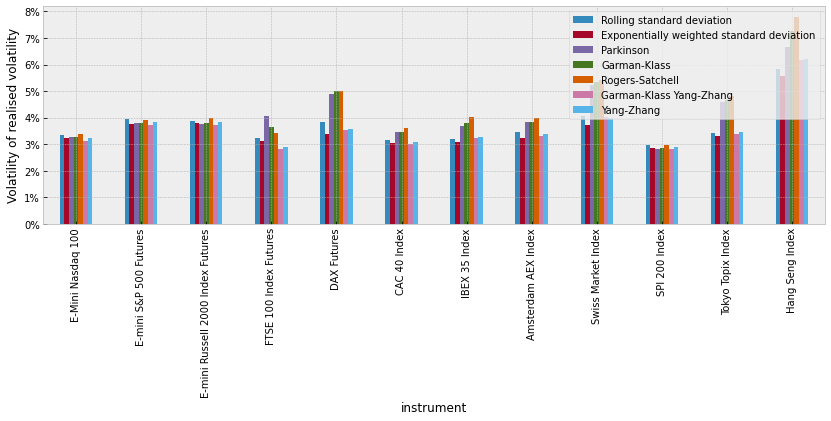

In [31]:
plot_vov(summary, 'equity')

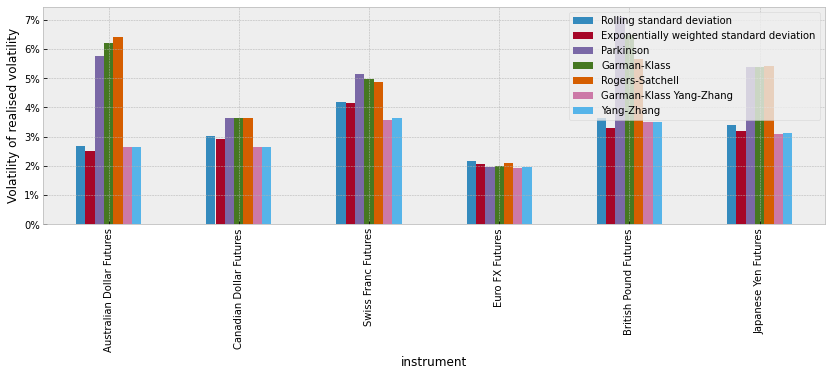

In [32]:
plot_vov(summary, 'currency')

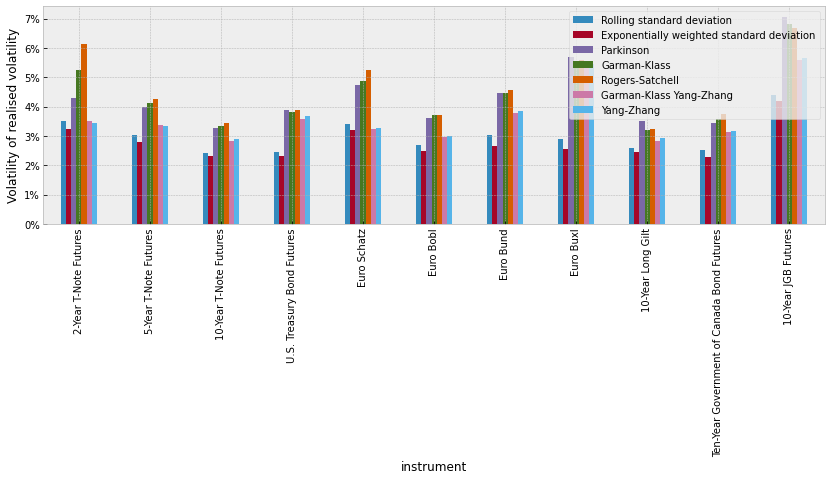

In [33]:
plot_vov(summary, 'fixed_income')

## Turnover reduction

The turnover reduction is measures against the rolling standard deviation.

$$
TurnoverReduction_{i} = 1 - \frac{Turnover_i}{Turnover_{RollingStdev}}
$$

where $i$ is the realised volatility measures other than the rolling standard deviation. A positive number means a turnover is lower which is more efficient assuming the target volatility is achieved.

Looking at the bar charts below, overall the Garman-Klass Yang-Zhang and Yang-Zhang seem to be more efficient. All futures contracts experimented in this notebook exhibit positive turnover reductions.

In [34]:
def plot_turnover_reduction(summary: pd.DataFrame, asset_class: str):
    turnover_table = (summary.query(f'asset_class == "{asset_class}"')
         .pivot_table('annualised_turnover', index='instrument', columns='realised_volatility_name')
         .reindex(columns=rv_names)
         .reindex(index=all_futures_baltas2020.query(f'asset_class == "{asset_class}"')['name'].tolist()))
    turnover_reduction = 1 - turnover_table.div(turnover_table['Rolling standard deviation'], axis=0)
    turnover_reduction = turnover_reduction.drop('Rolling standard deviation', axis=1)

    ax = turnover_reduction.plot(kind='bar', figsize=(14, 4));

    ax.axhline(0, color='black', lw=1, ls='--')
    ax.legend(loc='lower right')
    ax.set_ylabel('Turnover reduction')
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0));

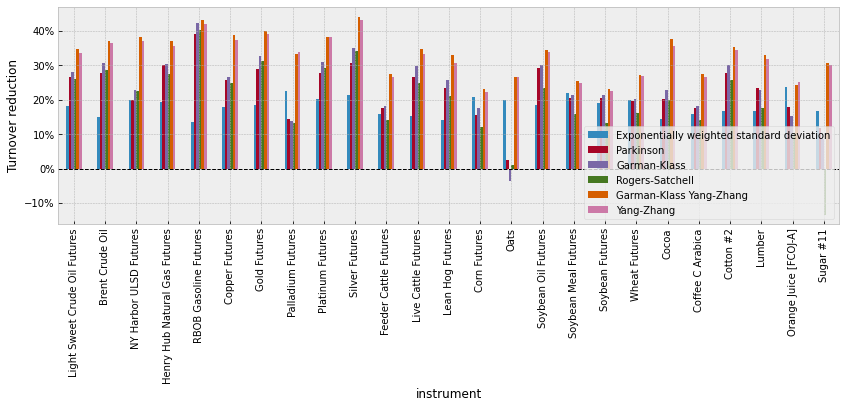

In [35]:
plot_turnover_reduction(summary, 'commodity')

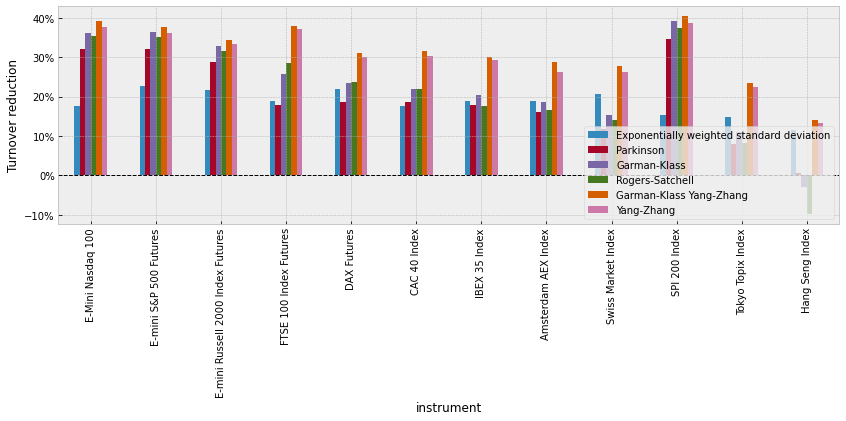

In [36]:
plot_turnover_reduction(summary, 'equity')

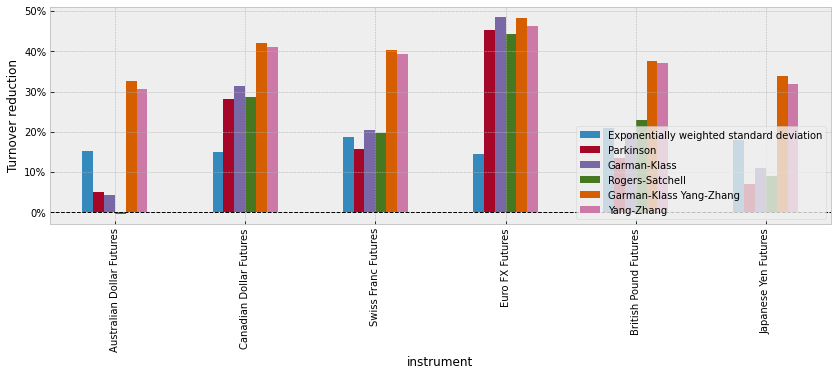

In [37]:
plot_turnover_reduction(summary, 'currency')

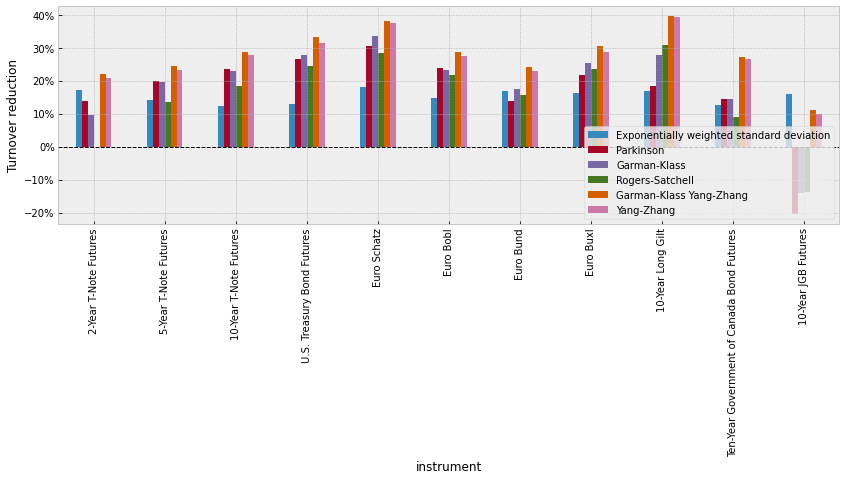

In [38]:
plot_turnover_reduction(summary, 'fixed_income')

# Reference
- Baltas, N. and Kosowski, R., 2020. Demystifying time-series momentum strategies: Volatility estimators, trading rules and pairwise correlations. Market Momentum: Theory and Practice", Wiley.
- Santander, 2012, Measuring Historical Volatility.